In [1]:
import os
from pathlib import Path
from gurobipy import Model, GRB
from data_loader import load_prices, load_storage, load_efficiency, load_plant_capacity, load_demand
import pandas as pd
import numpy as np

# Data Loading from data folder in the parent directory
current_dir = Path().resolve()
data_folder = os.path.join(current_dir.parent, "data")
fuel_prices_file = os.path.join(data_folder, "fuel_prices.csv")           # Price in EUR/tonne (coal,oil) or EUR/m3 (gas)
storage_file = os.path.join(data_folder, "storage.csv")         # Max storage in tonnes/m3
efficiency_file = os.path.join(data_folder, "efficiency.csv")   # efficiency of MWh th to MWh el
plant_file = os.path.join(data_folder, "plant_capacity.csv")    # Plant capacity in MWh/month
demand_file = os.path.join(data_folder, "electricity_demand.csv")           # Monthly demand in MWh

start_date = "2019-01"
end_date = "2022-12"
fuels = ["coal", "oil", "gas"]
zone = 'DK_1'  # Specify the zone for demand data
resample_method = 'M' # Monthly resampling 

try:
    fuel_prices_df = load_prices(fuel_prices_file, start_date, end_date, resample_method= resample_method)
    storage = load_storage(storage_file)
    efficiency = load_efficiency(efficiency_file)
    plant_capacity = load_plant_capacity(plant_file)
    demand_df = load_demand(demand_file, start_date, end_date, resample_method= resample_method ,zone=zone ,supply_factor=0.0005)
except Exception as e:
    raise RuntimeError(f"Error loading data: {e}")


# Timesteps
T = list(range(len(demand_df)))

# Model Initialization

m = Model("Fuel_Procurement_OneMonth")

F = [fuel for fuel in fuel_prices_df.columns if fuel in fuels]

# Decision Variables
# Decision Variables (corrected filters)
x = {(fuel, t): m.addVar(lb=0, ub=storage[fuel], name=f"buy_{fuel}_{t}")
     for fuel in F for t in T}

y = {(fuel, t): m.addVar(lb=0, ub=plant_capacity[fuel], name=f"gen_{fuel}_{t}")
     for fuel in F for t in T}

s = {(fuel, t): m.addVar(lb=0, ub=storage[fuel], name=f"s_{fuel}_{t}")
     for fuel in F for t in T}

m.update()



c:\Users\bjsb\OneDrive - NRGi A S\Gammelt H drev\PhD\Kurser\46750 Optimization in Power Systems\Assignment2group28\46750_g28_Assignment_2\src\data_loader.py:81: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(resample_method).mean()


Set parameter Username
Set parameter LicenseID to value 2728218
Academic license - for non-commercial use only - expires 2026-10-27


c:\Users\bjsb\OneDrive - NRGi A S\Gammelt H drev\PhD\Kurser\46750 Optimization in Power Systems\Assignment2group28\46750_g28_Assignment_2\src\data_loader.py:193: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df[selected_col].resample(resample_method).sum()


In [2]:
# Initial Storage Levels
initial_storage = {fuel: 0 for fuel in fuel_prices_df.columns if fuel in fuels}

# Constraints

# --- Add consumption (withdrawal) variables so stored fuel can be used later ---
# w = fuel consumed in a period (units same as storage units MWh th)
w = {(fuel, t): m.addVar(lb=0, ub=storage[fuel], name=f"cons_{fuel}_{t}")
     for fuel in F for t in T}

m.update()

# Demand constraint: one per time period
for t in T:
    m.addConstr(
        sum(y[fuel, t] for fuel in F) >= int(demand_df.iloc[t][zone]),
        name=f"Demand_Constraint_{t}"
    )

# efficiency constraints
for fuel in F:
    for t in T:
        m.addConstr(
            y[fuel, t] == efficiency[fuel] * w[fuel, t],
            name=f"Gen_from_Consumption_{fuel}_{t}"
        )

m.update()

# State-of-energy (SOE) constraints: storage evolves with buys (x) and withdrawals (w)
for fuel in F:
    print(f"Setting up SOE constraints for {fuel}")
    for t in T:
        print(f"  Time period {t}")
        if t == 0:
            m.addConstr(
                s[fuel, t] == initial_storage[fuel] + x[fuel, t] - w[fuel, t],
                name=f"SOE_Def_{fuel}_{t}"
            )
        else:
            m.addConstr(
                s[fuel, t] == s[fuel, t-1] + x[fuel, t] - w[fuel, t],
                name=f"SOE_Def_{fuel}_{t}"
            )

# Storage limits (explicit upper bound)
for fuel in F:
    for t in T:
        m.addConstr(
            s[fuel, t] <= storage[fuel],
            name=f"SOE_Limit_{fuel}_{t}"
        )

# Cyclic SOE (start == end)
t0 = 0
t4 = T[-1]   # last period
for fuel in F:
    m.addConstr(
        s[fuel, t0] == s[fuel, t4],
        name=f"SOE_Cycle_{fuel}"
    )

# Objective
m.setObjective(
    sum(fuel_prices_df.iloc[t][fuel] * x[fuel, t] for fuel in F for t in T),
    GRB.MINIMIZE
)
m.update()

# Optimize
m.optimize()

# print results
if m.status == GRB.OPTIMAL:
    print("Optimal Solution Found:")
    # Purchased and generated per fuel and period
    for (fuel, t) in sorted(x.keys()):
        print(f"Purchased {x[fuel, t].X:.4f} units of {fuel} at period {t}")
    for (fuel, t) in sorted(y.keys()):
        print(f"Generated {y[fuel, t].X:.4f} MWh from {fuel} at period {t}")
    for (fuel, t) in sorted(s.keys()):
        print(f"Stored {s[fuel, t].X:.4f} units of {fuel} at period {t}")

    # Cost per fuel aggregated across periods
    total_cost = 0.0
    for fuel in F:
        cost_f = sum(fuel_prices_df.iloc[t][fuel] * x[fuel, t].X for t in T)
        print(f"Cost for {fuel}: EUR {cost_f:.2f}")
        total_cost += cost_f

    print(f"Total Cost: EUR {total_cost:.2f}")
else:
    print("No optimal solution found.")


Setting up SOE constraints for coal
  Time period 0
  Time period 1
  Time period 2
  Time period 3
  Time period 4
  Time period 5
  Time period 6
  Time period 7
  Time period 8
  Time period 9
  Time period 10
  Time period 11
  Time period 12
  Time period 13
  Time period 14
  Time period 15
  Time period 16
  Time period 17
  Time period 18
  Time period 19
  Time period 20
  Time period 21
  Time period 22
  Time period 23
  Time period 24
  Time period 25
  Time period 26
  Time period 27
  Time period 28
  Time period 29
  Time period 30
  Time period 31
  Time period 32
  Time period 33
  Time period 34
  Time period 35
  Time period 36
  Time period 37
  Time period 38
  Time period 39
  Time period 40
  Time period 41
  Time period 42
  Time period 43
  Time period 44
  Time period 45
  Time period 46
  Time period 47
Setting up SOE constraints for oil
  Time period 0
  Time period 1
  Time period 2
  Time period 3
  Time period 4
  Time period 5
  Time period 6
  Time peri

In [3]:
# 1) Scenario definitions
scenario_list = ["low", "standard", "high"]

# 2) Multiplicative factors per fuel and scenario
#    - Gas is most volatile, coal least volatile
#    - Factors are multiplicative: scaled_price = base_price * factor
price_factors = {
    "coal":    {"low": 0.97, "standard": 1.00, "high": 1.03},   # +/- ~3%
    "oil":     {"low": 0.92, "standard": 1.00, "high": 1.08},   # ~8% swing
    "gas":     {"low": 0.80, "standard": 1.00, "high": 1.25},   # large volatility
}

# If you have extra fuels (e.g. 'lignite') present in fuel_prices_df, we preserve them (standard=1.0)
for col in fuel_prices_df.columns:
    if col not in price_factors:
        price_factors[col] = {s: 1.0 for s in scenario_list}

# 3) Seasonal probabilities 
#    Rationale: fuels (especially gas) tend to show seasonal patterns (higher risk of high prices in winter).
#    Seasonal buckets: winter=Dec/Jan/Feb, spring=Mar/Apr/May, summer=Jun/Jul/Aug, autumn=Sep/Oct/Nov
seasonal_scenario_probs = {
    "winter": {"low": 0.10, "standard": 0.40, "high": 0.50},
    "spring": {"low": 0.25, "standard": 0.60, "high": 0.15},
    "summer": {"low": 0.40, "standard": 0.50, "high": 0.10},
    "autumn": {"low": 0.20, "standard": 0.60, "high": 0.20},
}

def month_to_season(month: int) -> str:
    if month in (12, 1, 2):
        return "winter"
    if month in (3, 4, 5):
        return "spring"
    if month in (6, 7, 8):
        return "summer"
    return "autumn"

# 4) Build scenario_prices (dict of DataFrames) and scenario probability DataFrame (indexed by original index)
scenario_prices = {s: fuel_prices_df.copy(deep=True) for s in scenario_list}

# Ensure index is datetime (should be already from your loader) and use it to create probabilities by period
index = fuel_prices_df.index
if not isinstance(index, pd.DatetimeIndex):
    # fallback: if index was integer-range, try to use a 'month' column if present
    if "month" in fuel_prices_df.columns:
        index = pd.to_datetime(fuel_prices_df["month"])
        for df in scenario_prices.values():
            df.index = index
    else:
        raise RuntimeError("fuel_prices_df must have a DatetimeIndex or a 'month' column parseable to dates.")

# Create a DataFrame of probabilities for each period
scenario_prob_df = pd.DataFrame(index=index, columns=scenario_list, dtype=float)

for ts in index:
    season = month_to_season(ts.month)
    probs = seasonal_scenario_probs[season]
    # assign same probabilities for all fuels in that month (you could vary by fuel if desired)
    scenario_prob_df.loc[ts, list(probs.keys())] = [probs[k] for k in scenario_list]

# 5) Create scaled price DataFrames
for scenario in scenario_list:
    df_scaled = fuel_prices_df.copy(deep=True)
    # apply fuel-specific factor for each column
    for fuel in df_scaled.columns:
        factor = price_factors.get(fuel, {}).get(scenario, 1.0)
        # multiply only numeric values
        df_scaled[fuel] = pd.to_numeric(df_scaled[fuel], errors="coerce") * factor
    scenario_prices[scenario] = df_scaled

# 6) Create objects used in stochastic model
scenario_index_to_t = {i: scenario for i, scenario in enumerate(scenario_list)}  # e.g. 0->"low"
# scenario probabilities per time-step as numpy array shaped (T, n_scenarios)
prob_array = scenario_prob_df[scenario_list].to_numpy(dtype=float)

# - scenario_prices: dict {scenario_name: DataFrame_of_scaled_prices}
# - scenario_prob_df: DataFrame indexed by time with columns ['low','standard','high'] giving probabilities
# - prob_array: numpy array (T x 3) with probabilities for building the stochastic model
# - scenario_list and scenario_index_to_t helpers



In [4]:
scenario_prob_df

,low,standard,high
Unnamed: 0,,,
2019-01-31,0.10,0.4,0.50
2019-02-28,0.10,0.4,0.50
2019-03-31,0.25,0.6,0.15
2019-04-30,0.25,0.6,0.15
2019-05-31,0.25,0.6,0.15
2019-06-30,0.40,0.5,0.10
2019-07-31,0.40,0.5,0.10
2019-08-31,0.40,0.5,0.10
2019-09-30,0.20,0.6,0.20


In [5]:
scenario_prices

{'low':                  coal        oil    lignite         gas
 Unnamed: 0                                             
 2019-01-31   9.099860  34.861172   8.360073   17.480400
 2019-02-28   8.272929  36.003840   7.600369   14.500286
 2019-03-31   7.968240  37.987798   7.320450   12.493806
 2019-04-30   6.500717  38.699801   5.972231   12.025600
 2019-05-31   6.493169  39.489628   5.965297   10.632129
 2019-06-30   5.601120  38.366194   5.145769    8.690000
 2019-07-31   6.313160  38.648859   5.799922    8.865935
 2019-08-31   6.200298  37.662490   5.696235    9.084258
 2019-09-30   6.612175  37.051689   6.074628   10.424267
 2019-10-31   6.610853  37.766457   6.073414   12.523355
 2019-11-30   6.199006  37.849787   5.695048   12.753600
 2019-12-31   5.978501  39.247885   5.492470   11.322968
 2020-01-31   5.699738  43.458809   5.236369    9.049161
 2020-02-29   5.405407  40.300435   4.965967    7.298621
 2020-03-31   5.250431  32.777376   4.823589    6.715742
 2020-04-30   4.993639  

In [6]:
# prerequisites: scenario_list, scenario_prices, scenario_prob_df must exist (as in your earlier cell)
assert "scenario_list" in globals(), "scenario_list not found. Run the stochastic input cell first."
assert "scenario_prices" in globals(), "scenario_prices not found. Run the stochastic input cell first."
assert "scenario_prob_df" in globals(), "scenario_prob_df not found. Run the stochastic input cell first."

# Map period index (Datetimes) -> integer t (must match T from deterministic model)
period_index = fuel_prices_df.index  # should be a DatetimeIndex
if not isinstance(period_index, pd.DatetimeIndex):
    raise RuntimeError("fuel_prices_df index must be a DatetimeIndex for per-period probabilities to work.")

# ensure length matches T
if len(period_index) != len(T):
    raise RuntimeError("Length of fuel_prices_df index does not match T. Check data loader outputs.")

# Build per-period per-scenario probability matrix prob_array[t, i_s]
# Keep scenario_list ordering stable
n_scen = len(scenario_list)
scenario_to_i = {s: i for i, s in enumerate(scenario_list)}

# Ensure scenario_prob_df has same index and columns order
scenario_prob_df = scenario_prob_df.reindex(index=period_index)  # align indexing
scenario_prob_df = scenario_prob_df[scenario_list]               # order columns as scenario_list
prob_array = scenario_prob_df.to_numpy(dtype=float)              # shape (T, n_scen)
if prob_array.shape != (len(T), n_scen):
    raise RuntimeError("prob_array shape mismatch; expected (T, n_scen).")

# Build extensive-form Gurobi model (scenario-indexed variables)
m_stoch = Model("Fuel_Procurement_Stochastic_ExtensiveForm")

x_s = {}    # purchase variables: x_s[(s,f,t)]
y_s = {}    # generation: y_s[(s,f,t)]
w_s = {}    # fuel consumed (withdrawn) in period: w_s[(s,f,t)]
soe_s = {}  # storage: s_s[(s,f,t)]

for sname in scenario_list:
    for f in F:
        for t in T:
            # same bounds as deterministic model
            x_s[(sname, f, t)] = m_stoch.addVar(lb=0, ub=storage[f], name=f"x_{sname}_{f}_{t}")
            y_s[(sname, f, t)] = m_stoch.addVar(lb=0, ub=plant_capacity[f], name=f"y_{sname}_{f}_{t}")
            w_s[(sname, f, t)] = m_stoch.addVar(lb=0, ub=storage[f], name=f"w_{sname}_{f}_{t}")
            soe_s[(sname, f, t)] = m_stoch.addVar(lb=0, ub=storage[f], name=f"s_{sname}_{f}_{t}")

m_stoch.update()

# Non-anticipativity: enforce decisions equal across scenarios for t=0 
if len(scenario_list) > 1:
    base_s = scenario_list[0]
    for f in F:
        for t in [0]:  # change to range(k+1) to make NA for more periods
            for sname in scenario_list[1:]:
                m_stoch.addConstr(x_s[(base_s, f, t)] == x_s[(sname, f, t)], name=f"NA_x_{f}_{t}_{sname}")
                m_stoch.addConstr(y_s[(base_s, f, t)] == y_s[(sname, f, t)], name=f"NA_y_{f}_{t}_{sname}")
                m_stoch.addConstr(w_s[(base_s, f, t)] == w_s[(sname, f, t)], name=f"NA_w_{f}_{t}_{sname}")
                m_stoch.addConstr(soe_s[(base_s, f, t)] == soe_s[(sname, f, t)], name=f"NA_s_{f}_{t}_{sname}")

# Scenario-wise constraints
for sname in scenario_list:
    price_df = scenario_prices[sname]  # not needed for constraints if only used in objective
    for t in T:
        # deterministic demand used per-scenario here (change if you want scenario-specific demand)
        m_stoch.addConstr(
            sum(y_s[(sname, f, t)] for f in F) >= float(demand_df.iloc[t][zone]),
            name=f"Demand_{sname}_{t}"
        )

    for f in F:
        for t in T:
            # link generation to fuel consumed: electricity = efficiency * fuel_withdrawn
            m_stoch.addConstr(
                y_s[(sname, f, t)] == efficiency[f] * w_s[(sname, f, t)],
                name=f"Conv_{sname}_{f}_{t}"
            )

            # SOE dynamics: storage increases with purchases x and decreases with withdrawals w
            if t == 0:
                m_stoch.addConstr(
                    soe_s[(sname, f, t)] == initial_storage[f] + x_s[(sname, f, t)] - w_s[(sname, f, t)],
                    name=f"SOE_def_{sname}_{f}_{t}"
                )
            else:
                m_stoch.addConstr(
                    soe_s[(sname, f, t)] == soe_s[(sname, f, t-1)] + x_s[(sname, f, t)] - w_s[(sname, f, t)],
                    name=f"SOE_def_{sname}_{f}_{t}"
                )

            # storage limit (explicit)
            m_stoch.addConstr(soe_s[(sname, f, t)] <= storage[f], name=f"SOE_lim_{sname}_{f}_{t}")

        # cyclic SOE
        m_stoch.addConstr(soe_s[(sname, f, 0)] == soe_s[(sname, f, T[-1])], name=f"SOE_cycle_{sname}_{f}")
        
m_stoch.update()

# Objective: expected cost using per-period probabilities prob_array[t, i_s]
expected_cost_expr = 0.0
for i_s, sname in enumerate(scenario_list):
    price_df = scenario_prices[sname]
    for t in T:
        prob_ts = float(prob_array[t, i_s])  # probability of scenario s at time t
        # guard: if prob_ts==0 we still include term (it will be zero)
        for f in F:
            p = price_df.iloc[t].get(f, np.nan)
            if pd.isna(p):
                p = 0.0
            expected_cost_expr += prob_ts * p * x_s[(sname, f, t)]

m_stoch.setObjective(expected_cost_expr, GRB.MINIMIZE)
m_stoch.update()

# Optimize
m_stoch.params.OutputFlag = 1
m_stoch.optimize()

# -------------------------
# RESULT EXTRACTION: DataFrames for deterministic model (m) and stochastic model (expected & scenario-level)
# -------------------------
# 1) Deterministic model results (the model 'm' you solved earlier)
# Build index labels (datetimes)
periods = list(period_index)  # DatetimeIndex -> list of timestamps
det_cols = []
for f in F:
    det_cols += [(f, 'bought'), (f, 'generated'), (f, 'stored')]
det_index = period_index

det_df = pd.DataFrame(index=det_index, columns=pd.MultiIndex.from_tuples(det_cols, names=['fuel','metric']), dtype=float)

# Fill deterministic values if model m was solved and variables exist
if 'm' in globals() and m.status == GRB.OPTIMAL:
    for t, ts in enumerate(periods):
        for f in F:
            # purchases x[(f,t)], generation y[(f,t)], storage s[(f,t)] -- adapt names if your deterministic vars were named differently
            det_df.loc[ts, (f, 'bought')] = x[(f, t)].X
            det_df.loc[ts, (f, 'generated')] = y[(f, t)].X
            det_df.loc[ts, (f, 'stored')] = s[(f, t)].X
else:
    print("Deterministic model 'm' not found or not optimal; skipping deterministic results table.")

# 2) Stochastic model expected results (using scenario probs per period)
# expected_purchase[t,f] = sum_s prob_array[t,s_i] * x_s[(s,f,t)].X
exp_cols = []
for f in F:
    exp_cols += [(f, 'bought_exp'), (f, 'generated_exp'), (f, 'stored_exp')]
exp_df = pd.DataFrame(index=det_index, columns=pd.MultiIndex.from_tuples(exp_cols, names=['fuel','metric']), dtype=float)

if m_stoch.status == GRB.OPTIMAL:
    for t, ts in enumerate(periods):
        for f in F:
            # expected purchase
            exp_buy = 0.0
            exp_gen = 0.0
            exp_storage = 0.0
            for i_s, sname in enumerate(scenario_list):
                prob_ts = float(prob_array[t, i_s])
                x_val = x_s[(sname, f, t)].X
                y_val = y_s[(sname, f, t)].X
                s_val = soe_s[(sname, f, t)].X
                exp_buy += prob_ts * x_val
                exp_gen += prob_ts * y_val
                exp_storage += prob_ts * s_val
            exp_df.loc[ts, (f, 'bought_exp')] = exp_buy
            exp_df.loc[ts, (f, 'generated_exp')] = exp_gen
            exp_df.loc[ts, (f, 'stored_exp')] = exp_storage
else:
    print("Stochastic model not optimal; expected results cannot be computed.")

# 3) Optionally, build scenario-level DataFrames (for diagnostics)
scenario_dfs = {}
if m_stoch.status == GRB.OPTIMAL:
    for sname in scenario_list:
        cols = []
        for f in F:
            cols += [(f, 'bought'), (f, 'generated'), (f, 'stored')]
        sdf = pd.DataFrame(index=det_index, columns=pd.MultiIndex.from_tuples(cols, names=['fuel','metric']), dtype=float)
        for t, ts in enumerate(periods):
            for f in F:
                sdf.loc[ts, (f, 'bought')] = x_s[(sname, f, t)].X
                sdf.loc[ts, (f, 'generated')] = y_s[(sname, f, t)].X
                sdf.loc[ts, (f, 'stored')] = soe_s[(sname, f, t)].X
        scenario_dfs[sname] = sdf

# 4) Print / show top rows to confirm
print("\nDeterministic results (first 6 rows):")
print(det_df.head(6))

print("\nStochastic expected results (first 6 rows):")
print(exp_df.head(6))

print("\nScenario sample (first 3 periods) per scenario:")
for sname in scenario_list:
    print(f"\nScenario: {sname} (first 3 rows):")
    print(scenario_dfs[sname].head(3))

# Optionally save to csv
restults_dir = os.path.join(current_dir.parent, "results", "model3")
#make sure results directory exists
os.makedirs(restults_dir, exist_ok=True)
# Save deterministic results
det_df.to_csv(os.path.join(restults_dir, "deterministic_results_by_fuel.csv"))
exp_df.to_csv(os.path.join(restults_dir, "stochastic_expected_results_by_fuel.csv"))
for sname, sdf in scenario_dfs.items():
    sdf.to_csv(os.path.join(restults_dir, f"scenario_{sname}_results_by_fuel.csv"))

print("\nSaved CSVs: deterministic_results_by_fuel.csv, stochastic_expected_results_by_fuel.csv, scenario_*.csv")

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1473 rows, 1728 columns and 3513 nonzeros
Model fingerprint: 0x58d8d465
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [5e-01, 1e+02]
  Bounds range     [4e+02, 5e+03]
  RHS range        [8e+02, 5e+03]
Presolve removed 905 rows and 459 columns
Presolve time: 0.00s
Presolved: 568 rows, 1269 columns, 2127 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.154182e+04   0.000000e+00      0s
     451    1.1270808e+06   0.000000e+00   0.000000e+00      0s

Solved in 451 iterations and 0.02 seconds (0.01 work units)
Optimal objective  1.127080760e+06

Deterministic results (first 6 rows):
fuel       

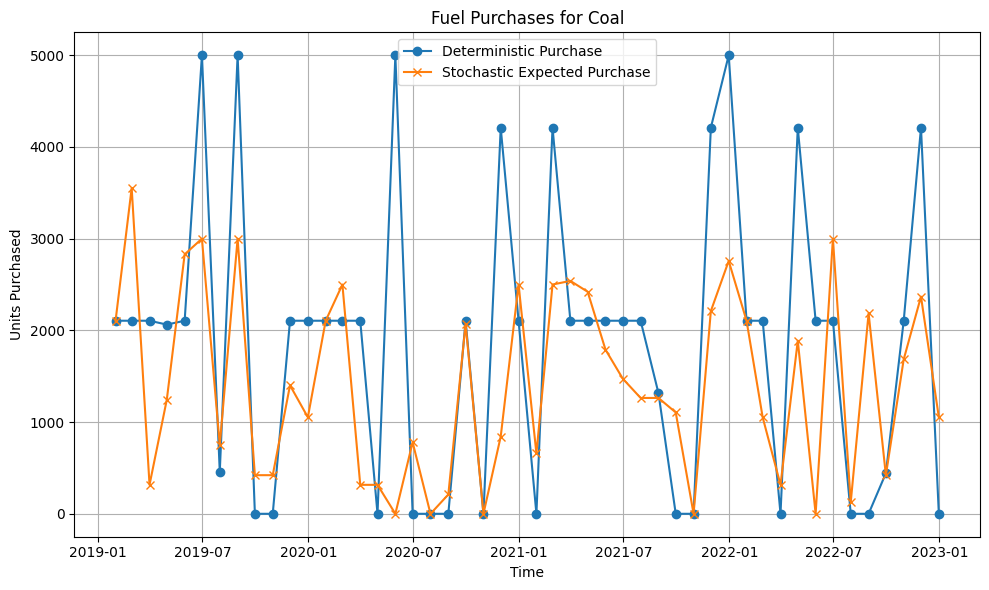

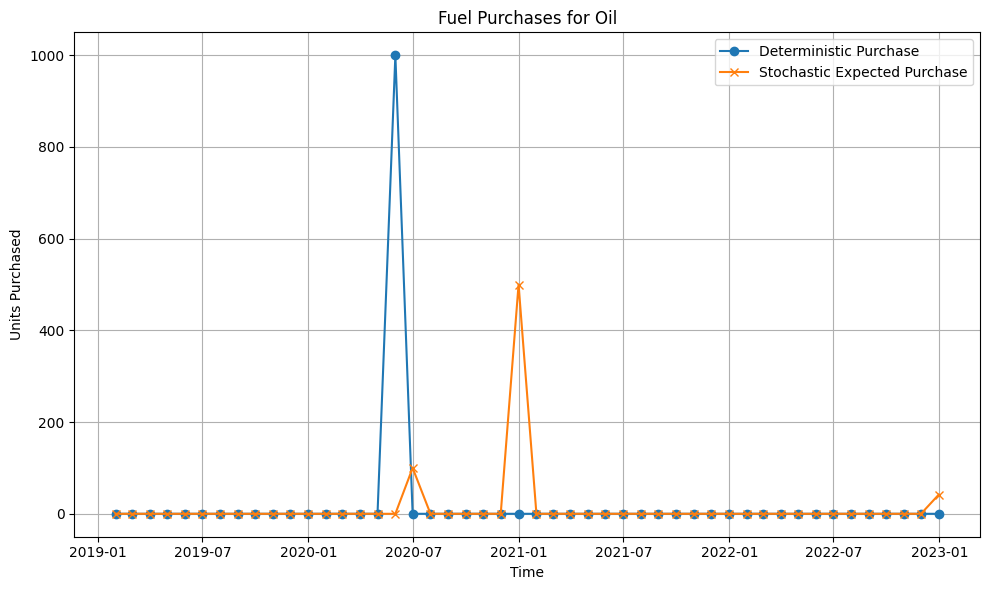

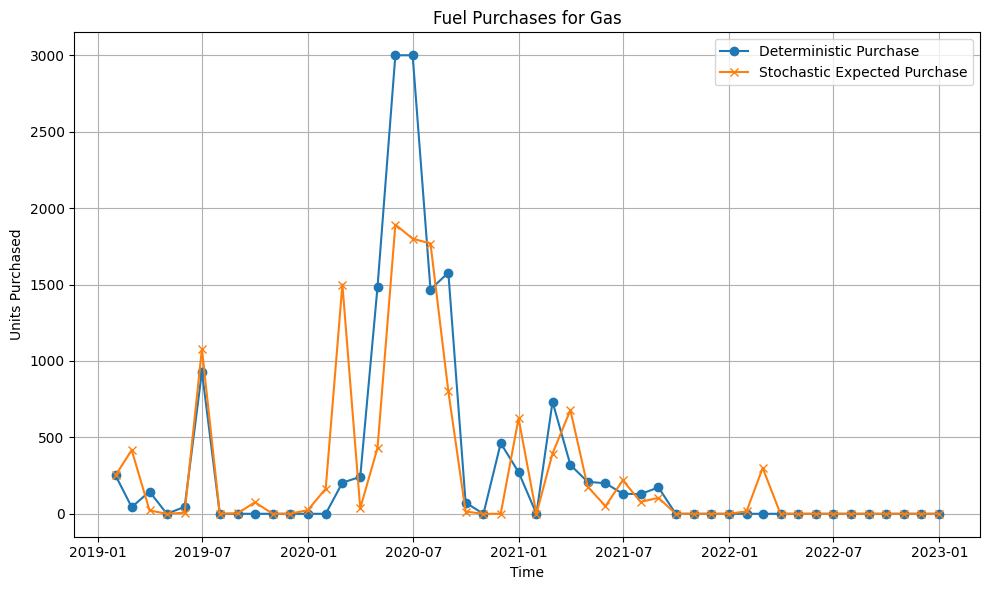

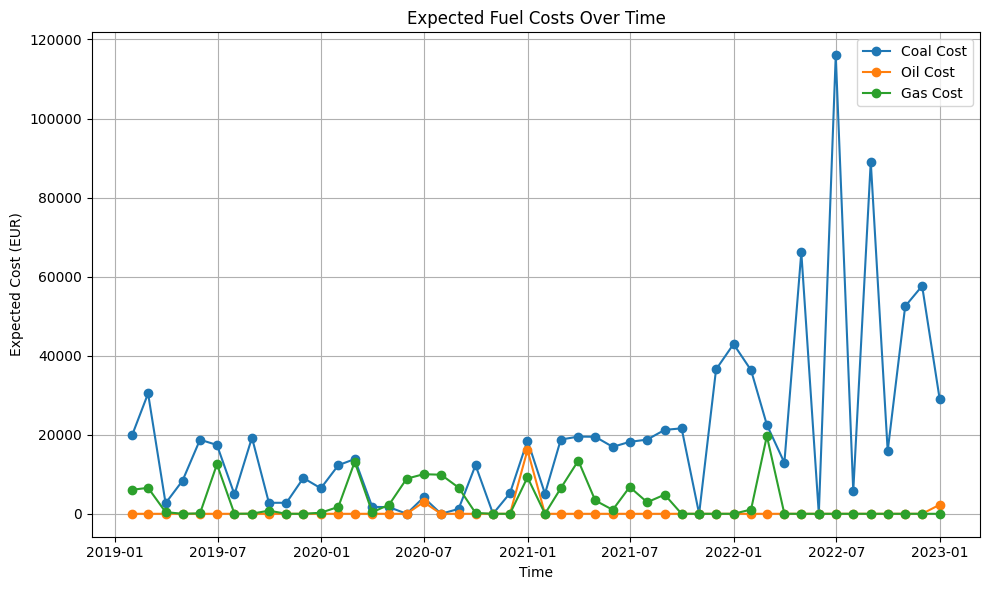

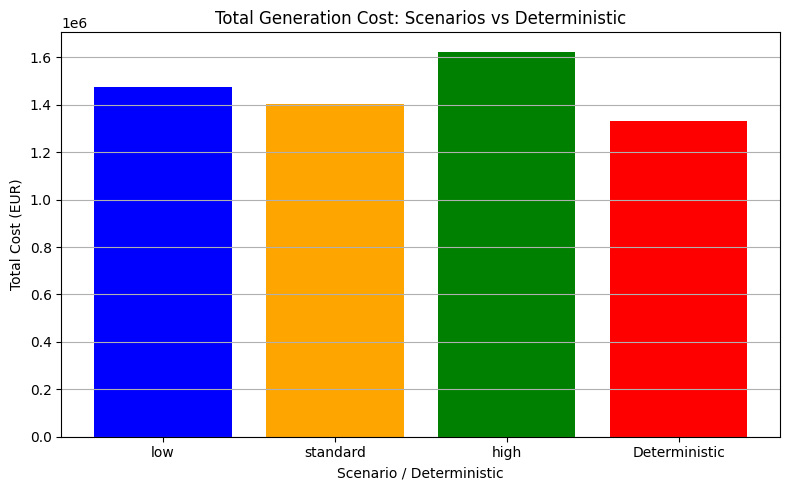

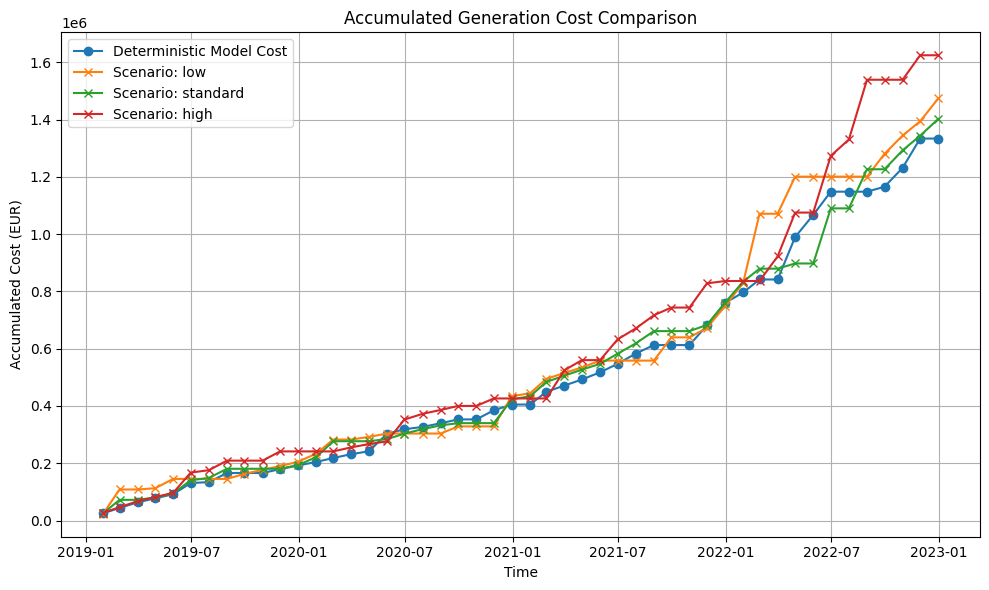

In [7]:
import matplotlib.pyplot as plt
# plot deterministic vs stochastic expected purchases for each fuel
for f in F:
    plt.figure(figsize=(10, 6))
    plt.plot(det_df.index, det_df[(f, 'bought')], label='Deterministic Purchase', marker='o')
    plt.plot(exp_df.index, exp_df[(f, 'bought_exp')], label='Stochastic Expected Purchase', marker='x')
    plt.title(f'Fuel Purchases for {f.capitalize()}')
    plt.xlabel('Time')
    plt.ylabel('Units Purchased')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot cost of each fuel per time period for stochastic model
fuel_costs = {f: [] for f in F}
for t in T:
    for f in F:
        cost_t_f = 0.0
        for sname in scenario_list:
            price_df = scenario_prices[sname]
            p = price_df.iloc[t].get(f, np.nan)
            if pd.isna(p):
                p = 0.0
            cost_t_f += prob_array[t, scenario_to_i[sname]] * p * x_s[(sname, f, t)].X
        fuel_costs[f].append(cost_t_f)
plt.figure(figsize=(10,6))
for f in F:
    plt.plot(periods, fuel_costs[f], label=f'{f.capitalize()} Cost', marker='o')
plt.title('Expected Fuel Costs Over Time')
plt.xlabel('Time')
plt.ylabel('Expected Cost (EUR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# Plot cost of generation per scenario as well as deterministic cost
# Scenario costs
scenario_costs = {}
for sname in scenario_list:
    total_cost = 0.0
    price_df = scenario_prices[sname]
    for t in T:
        for f in F:
            p = price_df.iloc[t].get(f, np.nan)
            if pd.isna(p):
                p = 0.0
            total_cost += p * x_s[(sname, f, t)].X
    scenario_costs[sname] = total_cost
# Deterministic cost
det_cost = 0.0
for t in T:
    for f in F:
        p = fuel_prices_df.iloc[t].get(f, np.nan)
        if pd.isna(p):
            p = 0.0
        det_cost += p * x[(f, t)].X
plt.figure(figsize=(8,5))
all_costs = scenario_costs.copy()
all_costs['Deterministic'] = det_cost
plt.bar(all_costs.keys(), all_costs.values(), color=['blue', 'orange', 'green', 'red'])
plt.title('Total Generation Cost: Scenarios vs Deterministic')
plt.xlabel('Scenario / Deterministic')
plt.ylabel('Total Cost (EUR)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Cumulative cost comparison between deterministic and stochastic models
model2_cost = []
for t in T:
    period_cost = 0.0
    for f in F:
        p = fuel_prices_df.iloc[t].get(f, np.nan)
        if pd.isna(p):
            p = 0.0
        period_cost += p * x[(f, t)].X
    model2_cost.append(period_cost)

# Plot Accumulated costs
plt.figure(figsize=(10, 6))
plt.plot(periods, np.cumsum(model2_cost), label='Deterministic Model Cost', marker='o')

for sname, sdf in scenario_dfs.items():
    price_df = scenario_prices[sname]
    per_period_cost = []
    for t, ts in enumerate(periods):
        cost_t = 0.0
        for f in F:
            qty = sdf.loc[ts, (f, 'bought')]
            if pd.isna(qty):
                qty = 0.0
            p = price_df.loc[ts, f] if ts in price_df.index else price_df.iloc[t].get(f, 0.0)
            if pd.isna(p):
                p = 0.0
            cost_t += float(qty) * float(p)
        per_period_cost.append(cost_t)
    plt.plot(periods, np.cumsum(per_period_cost), label=f'Scenario: {sname}', marker='x')

plt.title('Accumulated Generation Cost Comparison')
plt.xlabel('Time')
plt.ylabel('Accumulated Cost (EUR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# model3_cost_expected = []
# for t in T:
#     period_cost = 0.0
#     for f in F:
#         cost_t_f = 0.0
#         for sname in scenario_list:
#             price_df = scenario_prices[sname]
#             p = price_df.iloc[t].get(f, np.nan)
#             if pd.isna(p):
#                 p = 0.0
#             cost_t_f += prob_array[t, scenario_to_i[sname]] * p * x_s[(sname, f, t)].X
#         period_cost += cost_t_f
#     model3_cost_expected.append(period_cost)

